In [1]:
%cd /mnt/i/Yuki/workspace/exercises/Gasyori100knock

/mnt/i/Yuki/workspace/exercises/Gasyori100knock


https://github.com/yoyoyo-yo/Gasyori100knock/tree/master/Question_41_50

# 準備

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
imori_img_path = 'Question_41_50/imori.jpg'
imori_img = cv2.imread(imori_img_path)

thorino_img_path = 'Question_41_50/thorino.jpg'
thorino_img = cv2.imread(thorino_img_path)

## OpenCV は BGR を採用しているので RGB に変換する
BGR を採用している理由は単なる歴史的経緯らしい

In [4]:
imori_img = imori_img[:, :, ::-1]
thorino_img = thorino_img[:, :, ::-1]

# 問題

## Q.41. Cannyエッジ検出 (Step.1) エッジ強度

In [5]:
orig = imori_img.copy()
lum = orig[:, :, 0] * 0.2126 + orig[:, :, 1] * 0.7152 + orig[:, :, 2] * 0.0722

padded = np.pad(lum, (2, 2), 'edge')

In [6]:
# gaussian_filter = np.array([
#     [1,  4,  6,  4, 1],
#     [4, 16, 24, 16, 4],
#     [6, 24, 36, 24, 6],
#     [4, 16, 24, 16, 4],
#     [1,  4,  6,  4, 1],
# ]) / 256

K = 5
sigma = 1.4

gaussian_filter = np.zeros((K, K))

for i in range(K):
    for j in range(K):
        gaussian_filter[i, j] = np.exp( -((i - K // 2) ** 2 + (j - K // 2) ** 2) / (2 * (sigma ** 2)))

gaussian_filter /= gaussian_filter.sum()

In [7]:
gf_img = np.zeros_like(lum)

for i in range(lum.shape[0]):
    for j in range(lum.shape[1]):
        gf_img[i, j] = np.sum(padded[i:i+5, j:j+5] * gaussian_filter, axis=(0, 1))

gf_img = np.clip(gf_img, 0, 255)
padded = np.pad(gf_img, (1, 1), 'edge')

In [8]:
fx = np.zeros_like(lum)
fy = np.zeros_like(lum)

hor_sobel_filter = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1],
])
ver_sobel_filter = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1],
])

for i in range(lum.shape[0]):
    for j in range(lum.shape[1]):
        fx[i, j] = np.sum(padded[i:i+3, j:j+3] * hor_sobel_filter)
        fy[i, j] = np.sum(padded[i:i+3, j:j+3] * ver_sobel_filter)

In [9]:
edge = np.sqrt(fx ** 2 + fy ** 2)
angle = np.arctan(fy / fx)

In [10]:
q_angle = np.zeros_like(angle)

angle = (angle * 180 / np.pi) % 180

q_angle[(angle <= 22.5) * (157.5 < angle)] = 0
q_angle[(22.5 < angle) * (angle <= 67.5)] = 45
q_angle[(67.5 < angle) * (angle <= 112.5)] = 90
q_angle[(112.5 < angle) * (angle <= 157.5)] = 135

q_angle = q_angle.astype(np.uint8)

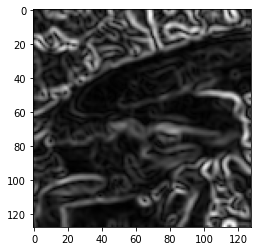

In [11]:
plt.imshow(edge, cmap='gray')

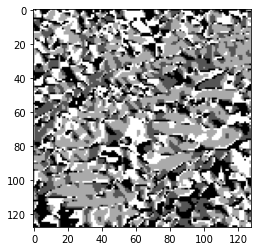

In [12]:
plt.imshow(q_angle, cmap='gray')

## Q.42. Cannyエッジ検出 (Step.2) 細線化

In [13]:
def non_maximum_suppression(angle, edge):
    H, W = angle.shape
    _edge = edge.copy()

    for y in range(H):
        for x in range(W):
                if angle[y, x] == 0:
                        dx1, dy1, dx2, dy2 = -1, 0, 1, 0
                elif angle[y, x] == 45:
                        dx1, dy1, dx2, dy2 = -1, 1, 1, -1
                elif angle[y, x] == 90:
                        dx1, dy1, dx2, dy2 = 0, -1, 0, 1
                elif angle[y, x] == 135:
                        dx1, dy1, dx2, dy2 = -1, -1, 1, 1
                if x == 0:
                        dx1 = max(dx1, 0)
                        dx2 = max(dx2, 0)
                if x == W-1:
                        dx1 = min(dx1, 0)
                        dx2 = min(dx2, 0)
                if y == 0:
                        dy1 = max(dy1, 0)
                        dy2 = max(dy2, 0)
                if y == H-1:
                        dy1 = min(dy1, 0)
                        dy2 = min(dy2, 0)
                if max(max(edge[y, x], edge[y + dy1, x + dx1]), edge[y + dy2, x + dx2]) != edge[y, x]:
                        _edge[y, x] = 0

    return _edge

In [14]:
fine_edge = edge.copy()
Y, X = fine_edge.shape

for y in range(Y):
    for x in range(X):
        if q_angle[y, x] == 0:
            dx1, dy1, dx2, dy2 = -1, 0, 1, 0
        elif q_angle[y, x] == 45:
            dx1, dy1, dx2, dy2 = -1, 1, 1, -1
        elif q_angle[y, x] == 90:
            dx1, dy1, dx2, dy2 = 0, -1, 0, 1
        elif q_angle[y, x] == 135:
            dx1, dy1, dx2, dy2 = -1, -1, 1, 1
        if x == 0:
            dx1 = max(dx1, 0)
            dx2 = max(dx2, 0)
        if x == X - 1:
            dx1 = min(dx1, 0)
            dx2 = min(dx2, 0)
        if y == 0:
            dy1 = max(dy1, 0)
            dy2 = max(dy2, 0)
        if y == Y - 1:
            dy1 = min(dy1, 0)
            dy2 = min(dy2, 0)
        if edge[y + dy1, x + dx1] > edge[y, x] or edge[y + dy2, x + dx2] > edge[y, x]:
            fine_edge[y, x] = 0

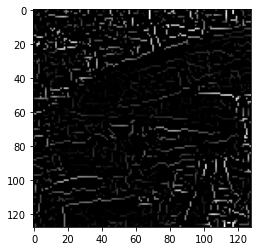

In [15]:
plt.imshow(fine_edge, cmap='gray')

## Q.43. Cannyエッジ検出 (Step.3) ヒステリシス閾処理

In [16]:
LT = 20
HT = 50

padded = np.pad(fine_edge, (1, 1), 'edge') 
canny = np.zeros_like(fine_edge, dtype=np.uint8)
H, W = canny.shape

for i in range(H):
    for j in range(W):
        if fine_edge[i, j] > LT:
            if np.max(padded[i:i+3,j:j+3]) > HT:
                canny[i, j] = 255

canny[fine_edge > HT] = 255

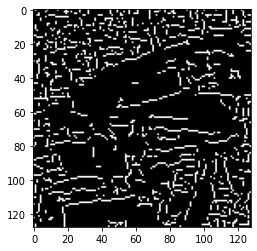

In [17]:
plt.imshow(canny, cmap='gray')

## Q.44. Hough変換・直線検出 (Step.1) Hough変換

In [18]:
orig = thorino_img.copy()
lum = orig[:, :, 0] * 0.2126 + orig[:, :, 1] * 0.7152 + orig[:, :, 2] * 0.0722

padded = np.pad(lum, (2, 2), 'edge')

In [19]:
# gaussian_filter = np.array([
#     [1,  4,  6,  4, 1],
#     [4, 16, 24, 16, 4],
#     [6, 24, 36, 24, 6],
#     [4, 16, 24, 16, 4],
#     [1,  4,  6,  4, 1],
# ]) / 256

K = 5
sigma = 1.4

gaussian_filter = np.zeros((K, K))

for i in range(K):
    for j in range(K):
        gaussian_filter[i, j] = np.exp( -((i - K // 2) ** 2 + (j - K // 2) ** 2) / (2 * (sigma ** 2)))

gaussian_filter /= gaussian_filter.sum()

In [20]:
gf_img = np.zeros_like(lum)

for i in range(lum.shape[0]):
    for j in range(lum.shape[1]):
        gf_img[i, j] = np.sum(padded[i:i+5, j:j+5] * gaussian_filter, axis=(0, 1))

gf_img = np.clip(gf_img, 0, 255)
padded = np.pad(gf_img, (1, 1), 'edge')

In [21]:
fx = np.zeros_like(lum)
fy = np.zeros_like(lum)

hor_sobel_filter = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1],
])
ver_sobel_filter = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1],
])

for i in range(lum.shape[0]):
    for j in range(lum.shape[1]):
        fx[i, j] = np.sum(padded[i:i+3, j:j+3] * hor_sobel_filter)
        fy[i, j] = np.sum(padded[i:i+3, j:j+3] * ver_sobel_filter)

In [22]:
edge = np.sqrt(fx ** 2 + fy ** 2)
fx_ = fx.copy()
fx_[np.abs(fx_) < 1e-10] = 1e-10
angle = np.arctan(fy / fx_)

In [23]:
q_angle = np.zeros_like(angle)

angle = (angle * 180 / np.pi) % 180

q_angle[(angle <= 22.5) * (157.5 < angle)] = 0
q_angle[(22.5 < angle) * (angle <= 67.5)] = 45
q_angle[(67.5 < angle) * (angle <= 112.5)] = 90
q_angle[(112.5 < angle) * (angle <= 157.5)] = 135

q_angle = q_angle.astype(np.uint8)

In [24]:
def non_maximum_suppression(angle, edge):
    H, W = angle.shape
    _edge = edge.copy()

    for y in range(H):
        for x in range(W):
                if angle[y, x] == 0:
                        dx1, dy1, dx2, dy2 = -1, 0, 1, 0
                elif angle[y, x] == 45:
                        dx1, dy1, dx2, dy2 = -1, 1, 1, -1
                elif angle[y, x] == 90:
                        dx1, dy1, dx2, dy2 = 0, -1, 0, 1
                elif angle[y, x] == 135:
                        dx1, dy1, dx2, dy2 = -1, -1, 1, 1
                if x == 0:
                        dx1 = max(dx1, 0)
                        dx2 = max(dx2, 0)
                if x == W-1:
                        dx1 = min(dx1, 0)
                        dx2 = min(dx2, 0)
                if y == 0:
                        dy1 = max(dy1, 0)
                        dy2 = max(dy2, 0)
                if y == H-1:
                        dy1 = min(dy1, 0)
                        dy2 = min(dy2, 0)
                if max(max(edge[y, x], edge[y + dy1, x + dx1]), edge[y + dy2, x + dx2]) != edge[y, x]:
                        _edge[y, x] = 0

    return _edge

In [25]:
fine_edge = edge.copy()
Y, X = fine_edge.shape

for y in range(Y):
    for x in range(X):
        if q_angle[y, x] == 0:
            dx1, dy1, dx2, dy2 = -1, 0, 1, 0
        elif q_angle[y, x] == 45:
            dx1, dy1, dx2, dy2 = -1, 1, 1, -1
        elif q_angle[y, x] == 90:
            dx1, dy1, dx2, dy2 = 0, -1, 0, 1
        elif q_angle[y, x] == 135:
            dx1, dy1, dx2, dy2 = -1, -1, 1, 1
        if x == 0:
            dx1 = max(dx1, 0)
            dx2 = max(dx2, 0)
        if x == X - 1:
            dx1 = min(dx1, 0)
            dx2 = min(dx2, 0)
        if y == 0:
            dy1 = max(dy1, 0)
            dy2 = max(dy2, 0)
        if y == Y - 1:
            dy1 = min(dy1, 0)
            dy2 = min(dy2, 0)
        if edge[y + dy1, x + dx1] > edge[y, x] or edge[y + dy2, x + dx2] > edge[y, x]:
            fine_edge[y, x] = 0

In [26]:
LT = 30
HT = 100

padded = np.pad(fine_edge, (1, 1), 'edge') 
canny = np.zeros_like(fine_edge, dtype=np.uint8)
H, W = canny.shape

for i in range(H):
    for j in range(W):
        if fine_edge[i, j] > LT:
            if np.max(padded[i:i+3,j:j+3]) > HT:
                canny[i, j] = 255

canny[fine_edge > HT] = 255

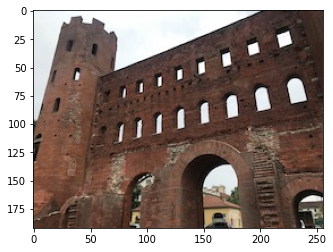

In [27]:
plt.imshow(orig, cmap='gray')

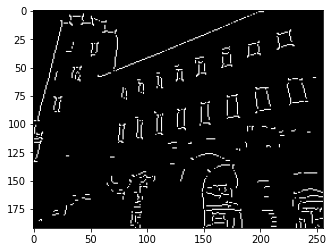

In [28]:
plt.imshow(canny, cmap='gray')

In [29]:
rmax = int((canny.shape[0] ** 2 + canny.shape[1] ** 2) ** 0.5)
voting_table = np.zeros((rmax * 2, 180))
for t in range(180):
    for y in range(canny.shape[0]):
        for x in range(canny.shape[1]):
            if canny[y][x] > 0:
                rho = int(x * np.cos(np.pi / 180 * t) + y * np.sin(np.pi / 180 * t))
                voting_table[rho + rmax, t] += 1

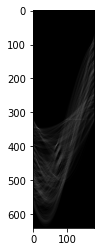

In [30]:
plt.imshow(voting_table, cmap='gray')

## Q.45. Hough変換・直線検出 (Step.2) NMS

In [31]:
votes = voting_table.copy()

for i in range(votes.shape[0]):
    for j in range(votes.shape[1]):
        min_i = max(0, i - 1)
        max_i = min(votes.shape[0], i + 2)
        min_j = max(0, j - 1)
        max_j = min(votes.shape[1], j + 2)
        if np.max(votes[min_i:max_i, min_j:max_j]) != votes[i, j]:
            votes[i, j] = 0

In [32]:
shape = votes.shape
flatten = votes.ravel()
flatten[np.argsort(flatten)[::-1][20:]] = 0
flatten[flatten > 0] = 255
maximal = flatten.reshape(shape)

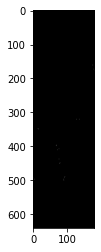

In [33]:
plt.imshow(maximal.astype(np.uint8), cmap='gray')

## Q.46. Hough変換・直線検出 (Step.3) Hough逆変換

In [34]:
detected = thorino_img.copy()
for r, t in zip(*np.where(maximal > 0)):
    r -= maximal.shape[0] // 2
    for px in range(-400, 400):
        x = r * np.cos(np.pi / 180 * t) - px * np.sin(np.pi / 180 * t)
        y = r * np.sin(np.pi / 180 * t) + px * np.cos(np.pi / 180 * t)
        x = int(x)
        y = int(y)
        if x < 0 or detected.shape[1] <= x:
            continue
        if y < 0 or detected.shape[0] <= y:
            continue
        detected[y, x] = [255, 0, 0]

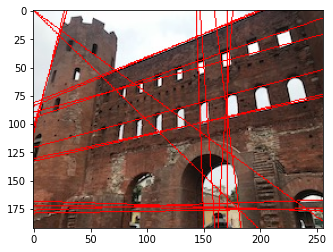

In [35]:
plt.imshow(detected)

## Q.47. モルフォロジー処理(膨張)

In [36]:
def get_ootsu_threshold(lum):
    best_score = None
    best_thre = None
    for i in range(256):
        w1 = np.sum(lum < i)
        w2 = np.sum(lum >= i)
        m1 = np.sum(lum[lum < i]) / (w1 + 1e-18)
        m2 = np.sum(lum[lum >= i]) / (w2 + 1e-18)
        score = w1 * w2 * (m1 - m2) ** 2
        if best_score is None or best_score < score:
            best_score = score
            best_thre = i
    
    return best_thre

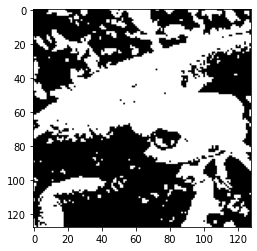

In [37]:
ootsu = imori_img.copy()
ootsu = ootsu[:, :, 0] * 0.2126 + ootsu[:, :, 1] * 0.7152 + ootsu[:, :, 2] * 0.0722
ootsu = ootsu.astype(np.uint8)

best_thre = get_ootsu_threshold(ootsu)

ootsu[ootsu < best_thre] = 0
ootsu[ootsu >= best_thre] = 255
plt.imshow(ootsu, cmap='gray')

In [38]:
def dilation(img):
    padded = np.pad(img, (1, 1), 'constant')
    filt = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0],
    ])
    
    ans = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if np.sum(padded[i:i+3, j:j+3] * filt) >= 255:
                ans[i, j] = 255

    return ans

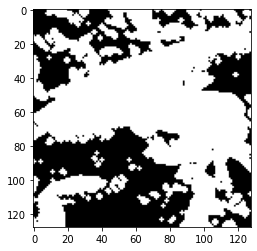

In [39]:
dilated = dilation(ootsu)
plt.imshow(dilated, cmap='gray')

## Q.48. モルフォロジー処理(収縮)

In [40]:
def erosion(img):
    padded = np.pad(img, (1, 1), 'constant')
    filt = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0],
    ])
    
    ans = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if np.sum(padded[i:i+3, j:j+3] * filt) < 255 * 4:
                ans[i, j] = 0

    return ans

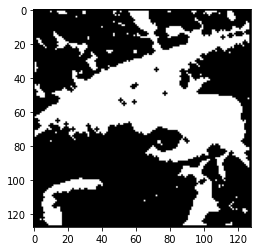

In [41]:
erosed = erosion(ootsu)
plt.imshow(erosed, cmap='gray')

## Q.49. オープニング処理

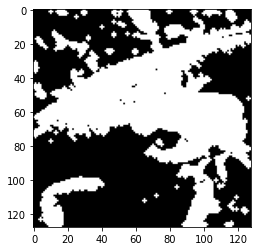

In [42]:
ans = dilation(erosion(ootsu))
plt.imshow(ans, cmap='gray')

## Q.50. クロージング処理

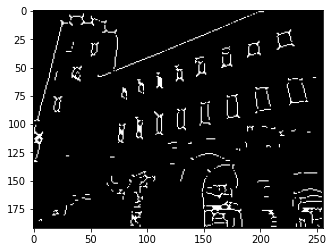

In [43]:
ans = erosion(dilation(canny))
plt.imshow(ans, cmap='gray')

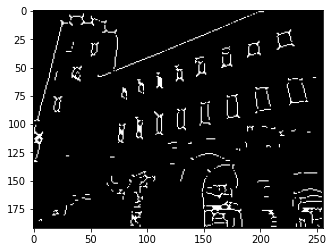

In [44]:
plt.imshow(ans, cmap='gray')